# Credit Card Approval Prediction
### Can we use banking information, past credit history, and statistical techniques to mitigate the risk to financial institutions by determining the factors that contribute to credit defaults? 

# Importing Packages and Data

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [3]:
df_cred = pd.read_csv(r"C:\Users\Eric\Documents\credit_record.csv")
df_cred.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## Status Values Explained

* 0: 1-29 days past due 
* 1: 30-59 days past due 
* 2: 60-89 days overdue 
* 3: 90-119 days overdue 
* 4: 120-149 days overdue 
* 5: Overdue or bad debts, write-offs for more than 150 days 
* C: paid off that month 
* X: No loan for the month

### There are no null values in the credit history table

In [4]:
df_cred.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [5]:
df_app = pd.read_csv(r"C:\Users\Eric\Documents\application_record.csv")
df_app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
df_app.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


### The only null values in the application data table are found in the OCCUPATION_TYPE column

In [7]:
df_app.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [8]:
df_app['OCCUPATION_TYPE'].value_counts()

Laborers                 78240
Core staff               43007
Sales staff              41098
Managers                 35487
Drivers                  26090
High skill tech staff    17289
Accountants              15985
Medicine staff           13520
Cooking staff             8076
Security staff            7993
Cleaning staff            5845
Private service staff     3456
Low-skill Laborers        2140
Secretaries               2044
Waiters/barmen staff      1665
Realty agents             1041
HR staff                   774
IT staff                   604
Name: OCCUPATION_TYPE, dtype: int64

# Cleaning the Data

### Since there are many different values for OCCUPATION_TYPE, the nulls are changed to 'Unknown'.

In [9]:
df_app['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

### The CNT_CHILDREN variable is adjusted to show when there are 0, 1, or 2+ children in the household.  

In [10]:
df_app['CNT_CHILDREN'].value_counts()

0     304071
1      88527
2      39884
3       5430
4        486
5        133
7          9
9          5
12         4
6          4
14         3
19         1
Name: CNT_CHILDREN, dtype: int64

In [11]:
df_app['CNT_CHILDREN'].replace([3,4,5,7,9,12,6,14,19], 2, inplace=True)

In [12]:
df_app['CNT_CHILDREN'].value_counts()

0    304071
1     88527
2     45959
Name: CNT_CHILDREN, dtype: int64

### The CNT_FAM_MEMBERS values make more sense as integers as opposed to floats. Outlier values are changed so that households of 5 or more are represented as one value. 

In [13]:
df_app['CNT_FAM_MEMBERS'] = df_app['CNT_FAM_MEMBERS'].astype(int)

In [14]:
df_app['CNT_FAM_MEMBERS'].value_counts()

2     233891
1      84492
3      77128
4      37356
5       5081
6        459
7        124
9          9
11         5
14         4
8          4
15         3
20         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [15]:
df_app['CNT_FAM_MEMBERS'].replace([5,6,7,8,9,11,14,15,20], 5, inplace=True)
df_app['CNT_FAM_MEMBERS'].value_counts()

2    233891
1     84492
3     77128
4     37356
5      5690
Name: CNT_FAM_MEMBERS, dtype: int64

### To make AMT_INCOME_TOTAL values more readable they are transformed to the thousandths integer and binned into categories separated by 25,000 with the value 500 representing an income of  500,000 or more.

In [16]:
df_app['AMT_INCOME_TOTAL'] = round(df_app['AMT_INCOME_TOTAL'].divide(1000))
#.astype(int)

In [17]:
cut_values = [50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500]
cut_bins = [0,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,2000]
df_app['AMT_INCOME_TOTAL'] = pd.cut(df_app['AMT_INCOME_TOTAL'], bins=cut_bins, labels=cut_values)

In [18]:
df_app['AMT_INCOME_TOTAL'] = df_app['AMT_INCOME_TOTAL'].astype(float)

### The values in the DAYS_BIRTH column are represented with negative numbers signifying the number of days since the person was born. To make this more readable, the values are transformed into positive integers of age in years and renamed AGE.

In [19]:
days_birth = np.array(df_app['DAYS_BIRTH'])
years_old = days_birth * -1 / 365
years_old = years_old.astype(int)
df_app.rename(columns={'DAYS_BIRTH':'AGE'}, inplace=True)
df_app['AGE'] = years_old

### The values of DAYS_EMPLOYED follow a similar pattern to the original DAYS_BIRTH column with retired individuals being assigned a value of 365243. Like the previous example, the DAYS_EMPLOYED variable is changed to YEARS_EMPLOYED represented by positive integers and retired individuals are assigned the value of -1.

In [20]:
df_app['DAYS_EMPLOYED'].replace({365243:365}, inplace=True)
days_employed = np.array(df_app['DAYS_EMPLOYED'])
years_employed = days_employed * -1 / 365
years_employed = years_employed.astype(int)
df_app.rename(columns={'DAYS_EMPLOYED':'YEARS_EMPLOYED'}, inplace=True)
df_app['YEARS_EMPLOYED'] = years_employed
df_app

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,450.0,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,Unknown,2
1,5008805,M,Y,Y,0,450.0,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,Unknown,2
2,5008806,M,Y,Y,0,125.0,Working,Secondary / secondary special,Married,House / apartment,58,3,1,0,0,0,Security staff,2
3,5008808,F,N,Y,0,275.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,Sales staff,1
4,5008809,F,N,Y,0,275.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,Sales staff,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,150.0,Pensioner,Secondary / secondary special,Separated,House / apartment,62,-1,1,0,0,0,Unknown,1
438553,6840222,F,N,N,0,125.0,Working,Secondary / secondary special,Single / not married,House / apartment,43,8,1,0,0,0,Laborers,1
438554,6841878,F,N,N,0,75.0,Commercial associate,Higher education,Single / not married,With parents,22,1,1,1,0,0,Sales staff,1
438555,6842765,F,N,Y,0,75.0,Pensioner,Secondary / secondary special,Married,House / apartment,59,-1,1,0,0,0,Unknown,2


# Determing the Default Label

In order to create the default label, I determined that an individual should be considered a risky credit resipient if there was a record of them having a payment that was overdue by 90 days or more on their account. A delinquent payment of 30 or 60 days seemed too premature to be labeled as unworthy of credit considering a default doesn't occur until a payment is 180 days late.

1. The first step is to find the unique IDs that exist in the credit record data and assign them all labels based on whether or not they have ever had a payment that was late by 90 days or longer in the past. 
2. Then these IDs can be joined with the credit application data so that we can see which IDs we have full information for. 

### First, I created a dataframe that contains all the unique IDs with a credit record and set their default label to 0.

In [21]:
cred_ids = np.array(df_cred['ID'])
cred_ids = np.unique(cred_ids)
df_labels = pd.DataFrame(cred_ids, columns =['ID'])
df_labels['LABELS'] = 0
df_labels

,ID,LABELS
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0
...,...,...
45980,5150482,0
45981,5150483,0
45982,5150484,0
45983,5150485,0


### Next, I created a LABEL column in the df_cred dataframe that assigned a value of 1 to the rows that showed default and 0 for all other values.

In [22]:
result = [] 
for value in df_cred['STATUS']: 
    if value == '3': 
        result.append(1)
    elif value == '4': 
        result.append(1) 
    elif value == '5':
        result.append(1)
    else: 
        result.append(0) 
       
df_cred['LABEL'] = result

### I was then able to create a dataframe of all the unique IDs who have a record of default.

In [23]:
def_ids = df_cred['ID'][df_cred['LABEL'] == 1].tolist()
def_ids = np.array(def_ids)
def_ids = np.unique(def_ids)
df_def = pd.DataFrame(def_ids, columns = ['ID'])
df_def['LABEL'] = 1
df_def

,ID,LABEL
0,5002126,1
1,5003267,1
2,5003471,1
3,5003712,1
4,5003804,1
...,...,...
326,5149192,1
327,5149698,1
328,5149828,1
329,5149834,1


### I then created a dataframe of all the non-defaults using a for loop with the df_labels and df_def dataframes.

In [24]:
all_id = df_labels['ID'].tolist()
def_id = df_def['ID'].tolist()

notdef_id = []
for value in all_id:
    if value not in def_id:
        notdef_id.append(value)

In [25]:
df_not_def = pd.DataFrame(notdef_id, columns =['ID'])
df_not_def['LABEL'] = 0
df_not_def = df_not_def.set_index('ID')
df_def = df_def.set_index('ID')
df_not_def

,LABEL
ID,
5001711,0
5001712,0
5001713,0
5001714,0
5001715,0
...,...
5150482,0
5150483,0
5150484,0


### Now with one table containing default IDs and another containing non-default IDs, I appended them together to create df_labels.

In [26]:
df_labels = df_not_def.append(df_def)
df_labels = df_labels.sort_index()
df_labels

,LABEL
ID,
5001711,0
5001712,0
5001713,0
5001714,0
5001715,0
...,...
5150482,0
5150483,0
5150484,0


### This table can then be joined with the application data to create a dataframe that consists of IDs for which there was both a credit record and application record.

In [27]:
df_app = df_app.set_index('ID')
df = df_app.join(df_labels, how='inner')
df

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,LABEL
ID,,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,450.0,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,Unknown,2,0
5008805,M,Y,Y,0,450.0,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,Unknown,2,0
5008806,M,Y,Y,0,125.0,Working,Secondary / secondary special,Married,House / apartment,58,3,1,0,0,0,Security staff,2,0
5008808,F,N,Y,0,275.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,Sales staff,1,0
5008809,F,N,Y,0,275.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,Sales staff,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,F,Y,Y,1,175.0,Working,Secondary / secondary special,Married,House / apartment,29,4,1,0,0,0,Core staff,3,0
5150483,F,Y,Y,1,175.0,Working,Secondary / secondary special,Married,House / apartment,29,4,1,0,0,0,Core staff,3,0
5150484,F,Y,Y,1,175.0,Working,Secondary / secondary special,Married,House / apartment,29,4,1,0,0,0,Core staff,3,0


# Data Exploration and Insights

In [28]:
cols_to_move = ['AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED', 'LABEL']
df = df[ cols_to_move + [ col for col in df.columns if col not in cols_to_move ]]
df

,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,LABEL,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,,,
5008804,450.0,32,12,0,M,Y,Y,0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2
5008805,450.0,32,12,0,M,Y,Y,0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2
5008806,125.0,58,3,0,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2
5008808,275.0,52,8,0,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1
5008809,275.0,52,8,0,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,175.0,29,4,0,F,Y,Y,1,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Core staff,3
5150483,175.0,29,4,0,F,Y,Y,1,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Core staff,3
5150484,175.0,29,4,0,F,Y,Y,1,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Core staff,3


### Less than 1% of all the data consists of defaults. Since the data is so imbalanced we will need to oversample later on to avoid underfitting. 

0    99.171627
1     0.828373
Name: LABEL, dtype: float64


Text(0, 0.5, 'Default Count')

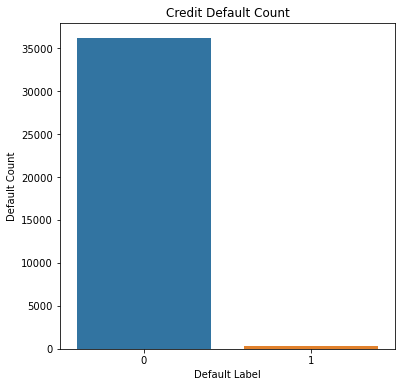

In [29]:
print(df['LABEL'].value_counts()/df.shape[0] *100)

fig = plt.figure(figsize=(6,6))
sns.countplot(x='LABEL',data=df)
plt.title('Credit Default Count')
plt.xlabel('Default Label')
plt.ylabel('Default Count')

# Distributions of Independent Variables

## Continuous Variables

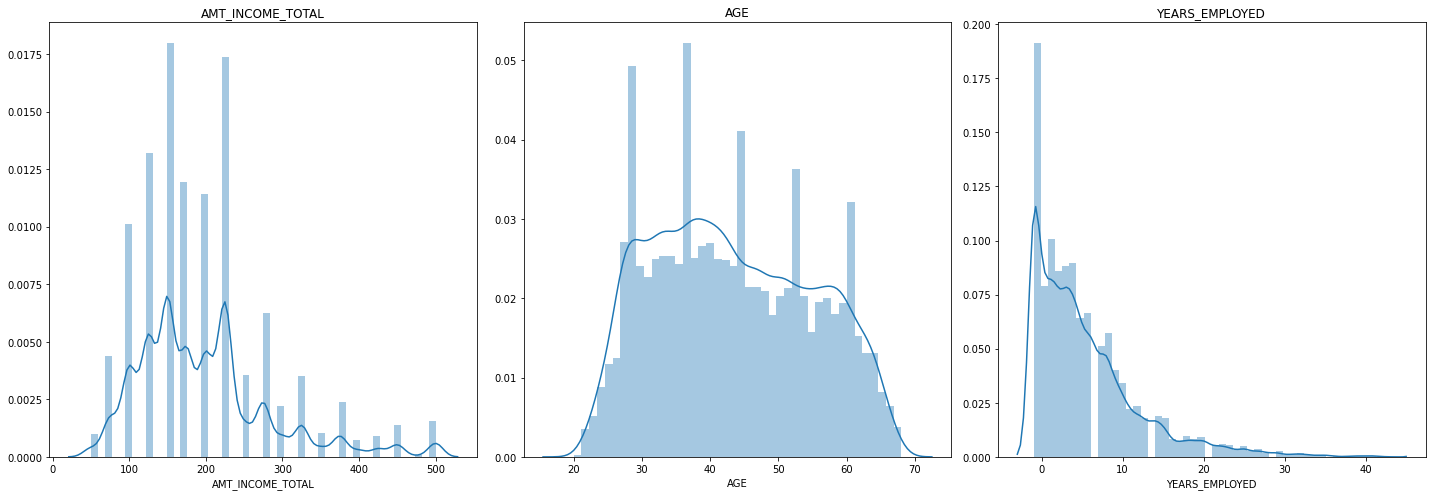

In [30]:
cols = df.iloc[:,:3]

fig = plt.figure(figsize = (20,7))

for i in range(0,3):
    plt.subplot(1, 3, i+1)
    sns.distplot(df.iloc[:,i])
    plt.title(df.columns[i])
    
plt.tight_layout()

## Categorical Variables

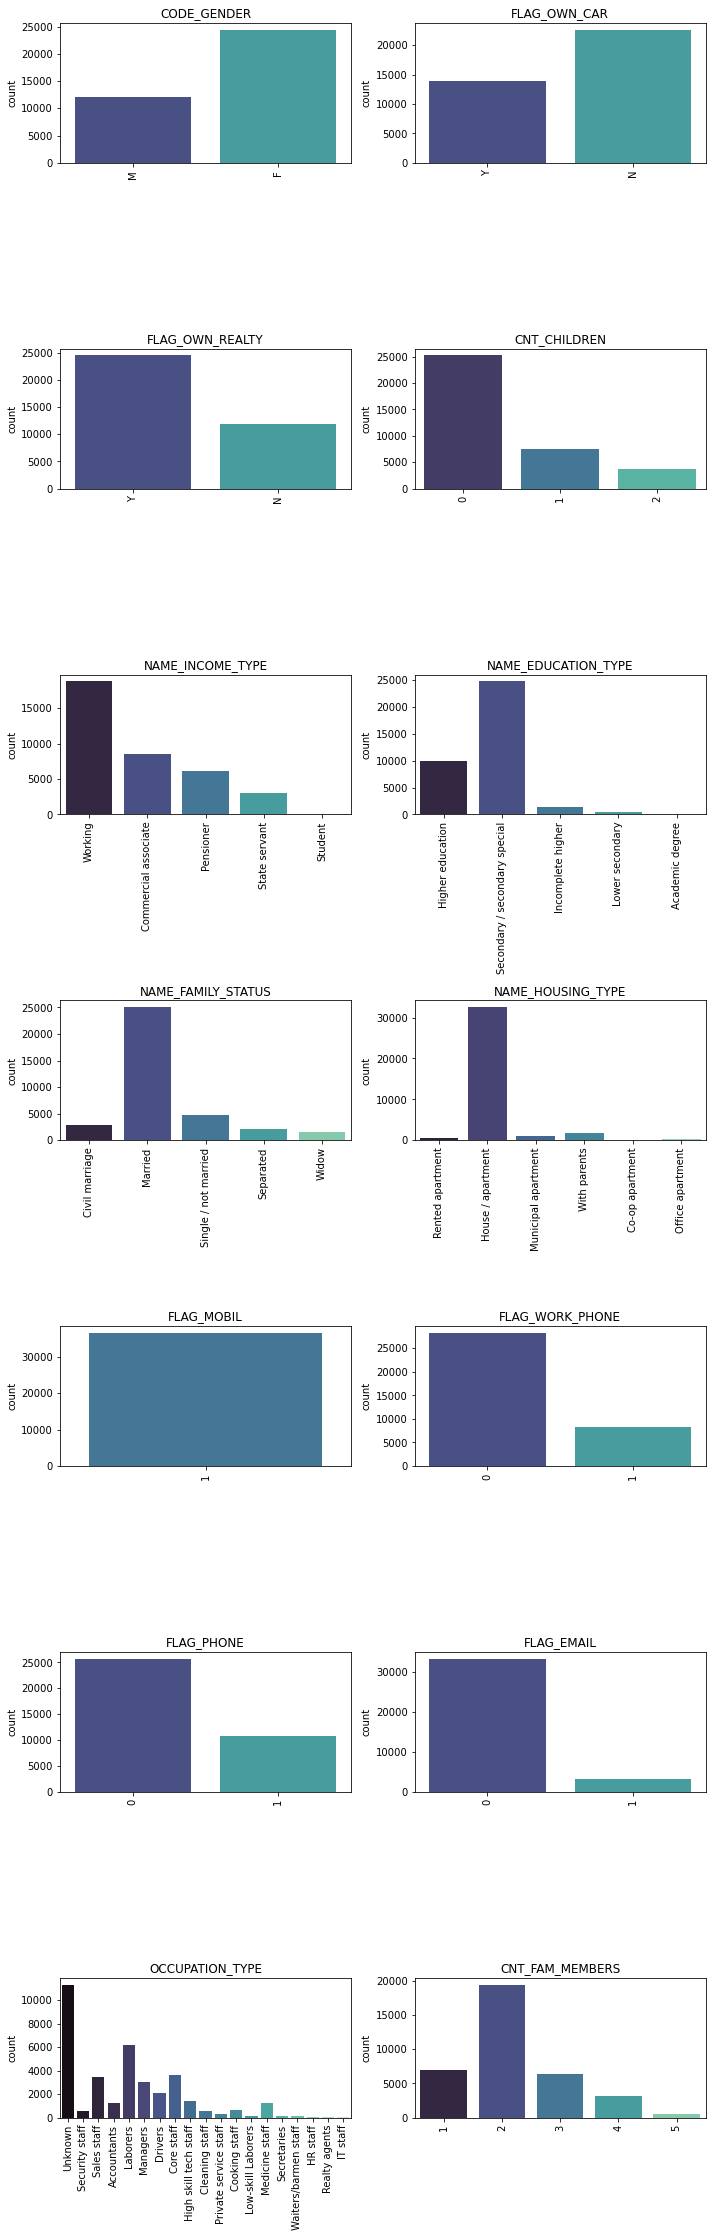

In [31]:
fig = plt.figure(figsize=(10, 40))

for i in range(4, 18):
    plt.subplot(9, 2, i+1)
    sns.countplot(x = df.iloc[:,i], data=df, palette='mako').set(xlabel=None)
    plt.title(df.columns[i])
    plt.xticks(rotation=90)
plt.tight_layout()


# Default Rates of Independent Variables

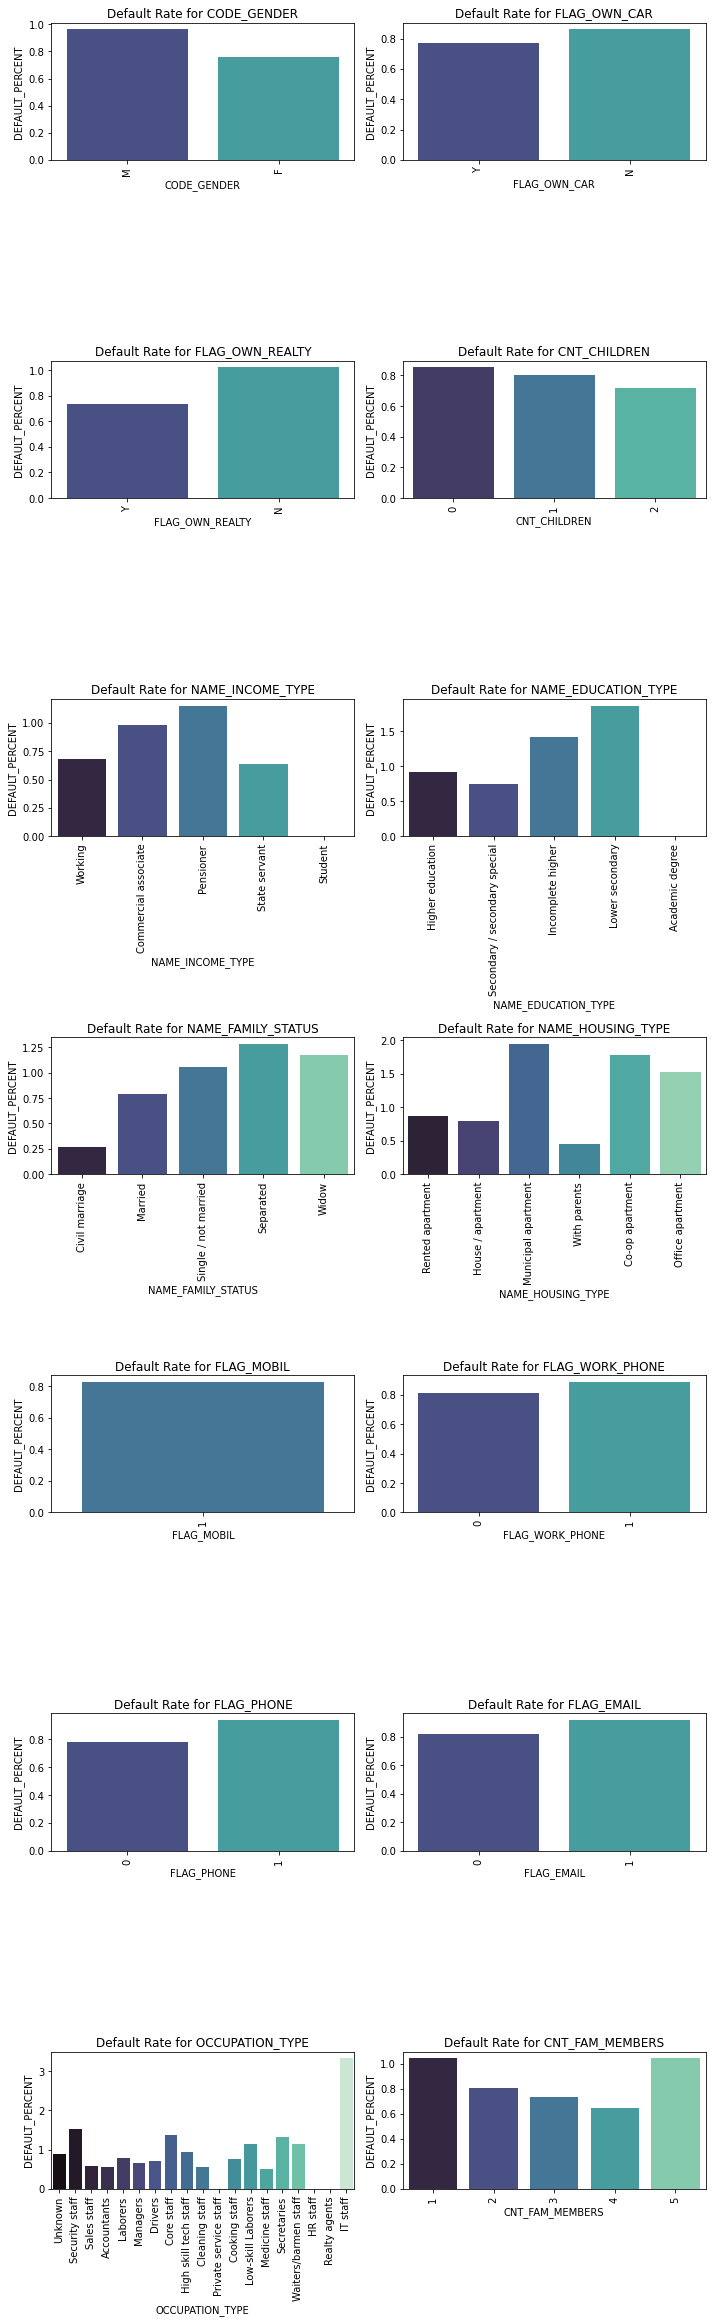

In [32]:
fig = plt.figure(figsize=(10, 40))

def percent_func(column,x):
    values = df[column].unique()
    dictionary = {key: None for key in values}

    for i in range(0, len(values)):
        defaults = df[column][(df[column] == values[i]) & (df['LABEL'] == 1)].shape[0]
        totals = df[column][df[column] == values[i]].shape[0]
        percent = defaults / totals * 100
        dictionary[values[i]] = percent
    
    df_percent = pd.DataFrame(list(dictionary.items()), columns = [column, 'DEFAULT_PERCENT'])
        
    plt.subplot(9, 2, x+1)
    sns.barplot(x=column, y='DEFAULT_PERCENT', data=df_percent, palette='mako')
    plt.xticks(rotation=(90))
    plt.title('Default Rate for {}'.format(column))
    plt.tight_layout()

percent_func('CODE_GENDER',0)
percent_func('FLAG_OWN_CAR',1)
percent_func('FLAG_OWN_REALTY',2)
percent_func('CNT_CHILDREN',3)
percent_func('NAME_INCOME_TYPE',4)
percent_func('NAME_EDUCATION_TYPE',5)
percent_func('NAME_FAMILY_STATUS',6)
percent_func('NAME_HOUSING_TYPE',7)
percent_func('FLAG_MOBIL',8)
percent_func('FLAG_WORK_PHONE',9)
percent_func('FLAG_PHONE',10)
percent_func('FLAG_EMAIL',11)
percent_func('OCCUPATION_TYPE',12)
percent_func('CNT_FAM_MEMBERS',13)

Text(0.5, 1.0, 'Default Rate by Income')

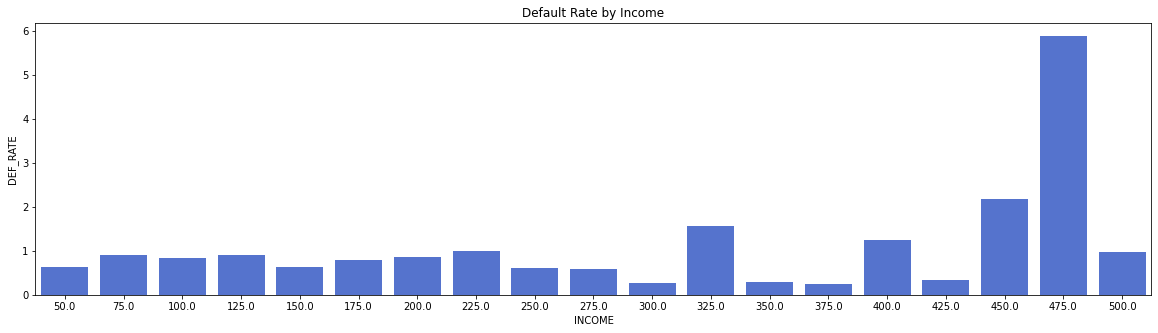

In [33]:
incomes = np.unique(df['AMT_INCOME_TOTAL'])
dict = {}

for i in range(0,len(incomes)):
        dict[incomes[i]] = ((df['AMT_INCOME_TOTAL'] == incomes[i])[df['LABEL'] == 1]).sum() / (df['AMT_INCOME_TOTAL'] == incomes[i]).sum() * 100

income_def_rate = pd.DataFrame(list(dict.items()), columns=['INCOME', 'DEF_RATE'])

fig = plt.figure(figsize=(20,5))
plot_ = sns.barplot(x='INCOME', y='DEF_RATE', data=income_def_rate, color='royalblue')
plt.title('Default Rate by Income')

Text(0.5, 1.0, 'Default Rate by Age')

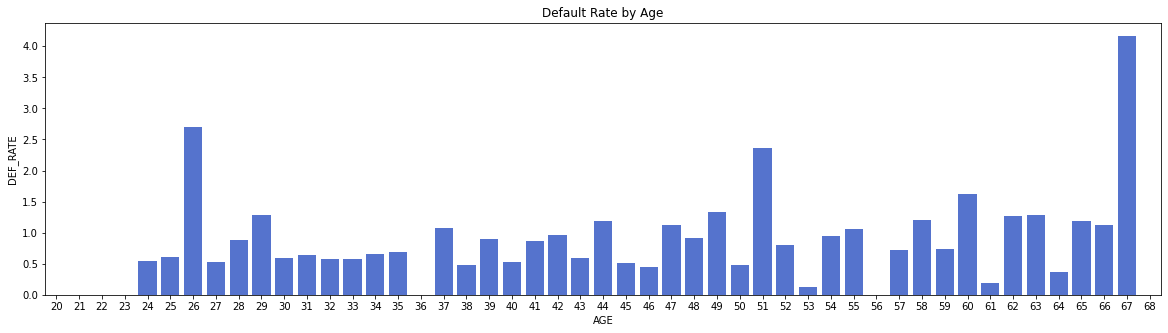

In [34]:
ages = np.unique(df['AGE'])
dict = {}

for i in range(20,69):
        dict[i] = ((df['AGE'] == i)[df['LABEL'] == 1]).sum() / (df['AGE'] == i).sum() * 100

age_def_rate = pd.DataFrame(list(dict.items()), columns=['AGE', 'DEF_RATE'])

plt.figure(figsize=(20,5))

sns.barplot(x='AGE', y='DEF_RATE', data=age_def_rate, color='royalblue')
plt.title('Default Rate by Age')

Text(0.5, 1.0, 'Default Rate by Years Employed')

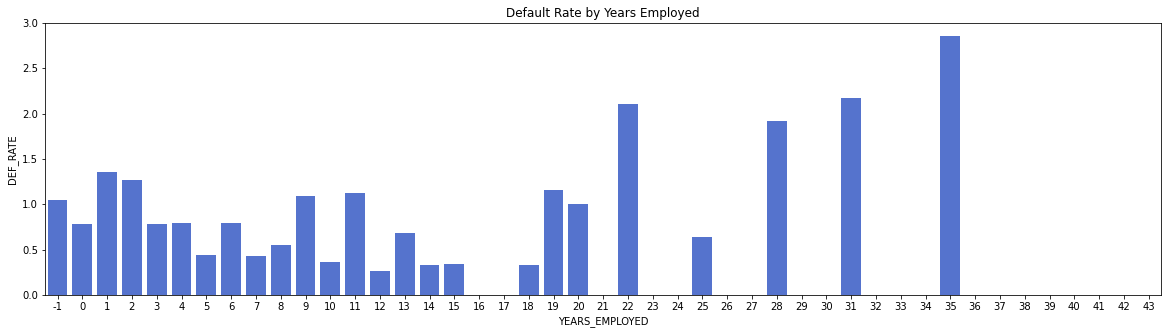

In [35]:
years_employed = np.unique(df['YEARS_EMPLOYED'])
dict_emp = {}

for i in range(-1,len(years_employed)-1):
        dict_emp[i] = ((df['YEARS_EMPLOYED'] == i)[df['LABEL'] == 1]).sum() / (df['YEARS_EMPLOYED'] == i).sum() * 100

emp_def_rate = pd.DataFrame(list(dict_emp.items()), columns=['YEARS_EMPLOYED', 'DEF_RATE'])

plt.figure(figsize=(20,5))
sns.barplot(x='YEARS_EMPLOYED', y='DEF_RATE', data=emp_def_rate, color='royalblue')
plt.title('Default Rate by Years Employed')

# Feature Selection

## To limit the data to only the most significant variables I decided to drop the 5 columns below. 
* OCCUPATION_TYPE contains many values with a majority of data points having an unknown occupation.
* FLAG_MOBIL was eliminated since every sample in the data appears to own a cell phone.
* FLAG_WORK_PHONE, FLAG_PHONE, and FLAG_EMAIL all appear to have a similar default rate between the 0 and 1 LABELS and the their distribution leans heavily towards people who do not have these forms of communication. 

In [36]:
df = df.drop(columns=['OCCUPATION_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'])
df

,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,LABEL,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,
5008804,450.0,32,12,0,M,Y,Y,0,Working,Higher education,Civil marriage,Rented apartment,2
5008805,450.0,32,12,0,M,Y,Y,0,Working,Higher education,Civil marriage,Rented apartment,2
5008806,125.0,58,3,0,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,2
5008808,275.0,52,8,0,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1
5008809,275.0,52,8,0,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,175.0,29,4,0,F,Y,Y,1,Working,Secondary / secondary special,Married,House / apartment,3
5150483,175.0,29,4,0,F,Y,Y,1,Working,Secondary / secondary special,Married,House / apartment,3
5150484,175.0,29,4,0,F,Y,Y,1,Working,Secondary / secondary special,Married,House / apartment,3


# Creating Dummy Variables

## Before running the logistic regression model, we need to transform the categorical variables using dummy variables.

In [37]:
data = pd.get_dummies(df, columns =['CODE_GENDER',
                                    'FLAG_OWN_CAR',
                                    'FLAG_OWN_REALTY',
                                    'NAME_INCOME_TYPE',
                                    'NAME_EDUCATION_TYPE',
                                    'NAME_FAMILY_STATUS',
                                    'NAME_HOUSING_TYPE'])

data.head()

,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,LABEL,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
ID,,,,,,,,,,,,,,,,,,,,,
5008804,450.0,32,12,0,0,2,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
5008805,450.0,32,12,0,0,2,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
5008806,125.0,58,3,0,0,2,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
5008808,275.0,52,8,0,0,1,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0
5008809,275.0,52,8,0,0,1,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0


## Now we can check to see the correlation of the independent variables in relation to default.

In [38]:
correlations = pd.DataFrame(data.corr()['LABEL'].sort_values())
correlations.reset_index(inplace=True)
correlations = correlations.rename(columns = {'LABEL':'CORRELATION', 'index':'INDEP_VAR'})
correlations

,INDEP_VAR,CORRELATION
0,YEARS_EMPLOYED,-0.019833
1,NAME_FAMILY_STATUS_Civil marriage,-0.018209
2,NAME_INCOME_TYPE_Working,-0.016285
3,FLAG_OWN_REALTY_Y,-0.014829
4,NAME_EDUCATION_TYPE_Secondary / secondary special,-0.013779
5,CODE_GENDER_F,-0.010538
6,CNT_FAM_MEMBERS,-0.010117
7,NAME_HOUSING_TYPE_With parents,-0.009436
8,NAME_HOUSING_TYPE_House / apartment,-0.009409
9,NAME_INCOME_TYPE_State servant,-0.006321


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

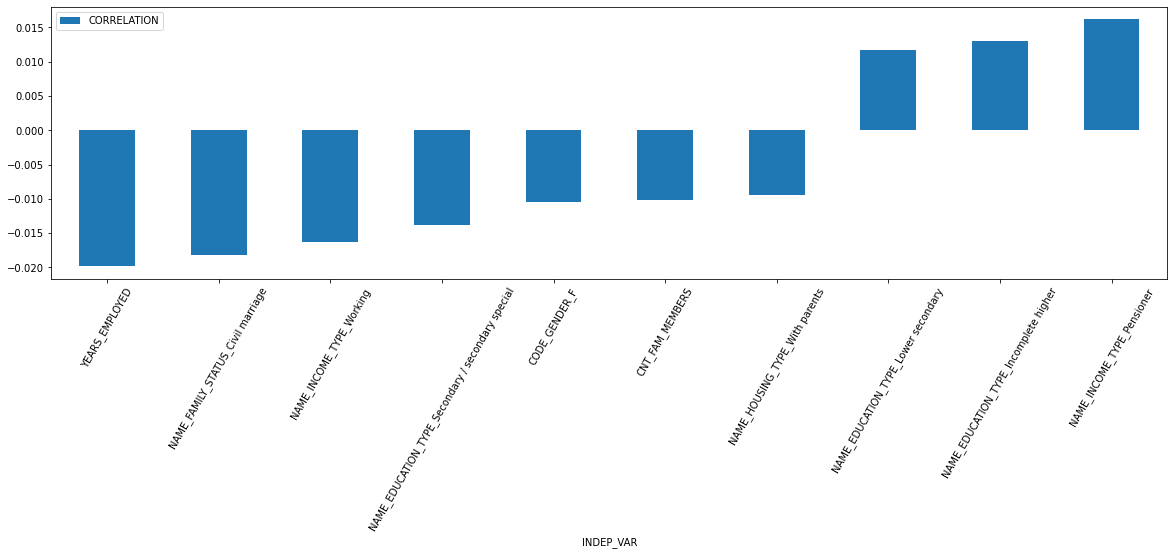

In [39]:
correlations = correlations.set_index('INDEP_VAR')
correlations = correlations.iloc[[0,1,2,4,5,6,7,26,28,30,32]]
correlations.iloc[:10,:].plot(kind='bar', figsize=(20,5))
plt.xticks(rotation=60)

In [40]:
data_new = data.loc[:, correlations.index]
data_new

INDEP_VAR,YEARS_EMPLOYED,NAME_FAMILY_STATUS_Civil marriage,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,CODE_GENDER_F,CNT_FAM_MEMBERS,NAME_HOUSING_TYPE_With parents,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Incomplete higher,NAME_INCOME_TYPE_Pensioner,LABEL
ID,,,,,,,,,,,
5008804,12,1,1,0,0,2,0,0,0,0,0
5008805,12,1,1,0,0,2,0,0,0,0,0
5008806,3,0,1,1,0,2,0,0,0,0,0
5008808,8,0,0,1,1,1,0,0,0,0,0
5008809,8,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5150482,4,0,1,1,1,3,0,0,0,0,0
5150483,4,0,1,1,1,3,0,0,0,0,0
5150484,4,0,1,1,1,3,0,0,0,0,0


# Checking Multicolinearity

# Correlation Heatmap

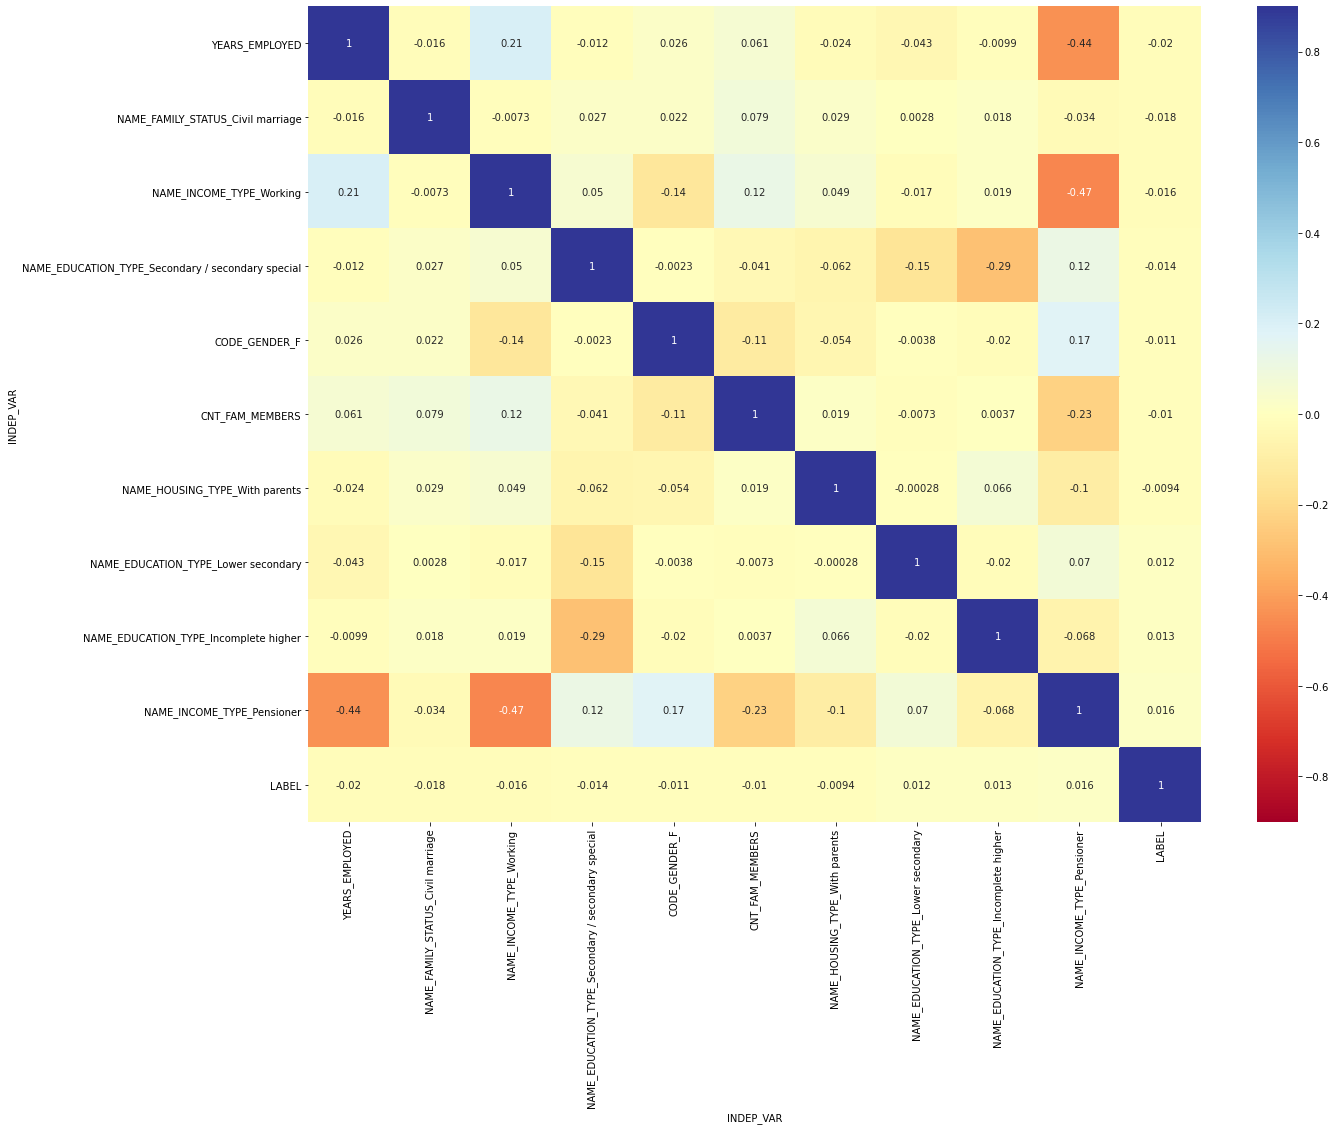

In [41]:
fig = plt.figure(figsize=(20,15))
sns.heatmap(data_new.corr(), cmap = plt.cm.RdYlBu, vmin = -0.9, annot = True, vmax = 0.9)

# Model Building and Logistic Regression

### This data skewed heavily towards non-default records and thus oversampling was required to avoid an underfitting of the data which would lead to high bias.

In [42]:
X = data_new.drop(['LABEL'], axis=1)
y = data_new['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [43]:
X_train.shape

(29165, 10)

In [44]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
smote = SMOTE(random_state = 1) 
X_train_res, y_train_res = smote.fit_sample(X_train, y_train) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 246
Before OverSampling, counts of label '0': 28919 

After OverSampling, the shape of train_X: (57838, 10)
After OverSampling, the shape of train_y: (57838,) 

After OverSampling, counts of label '1': 28919
After OverSampling, counts of label '0': 28919


In [45]:
logit = sm.Logit(y_train_res, X_train_res).fit()
yhat = logit.predict(X_test) 
prediction = list(map(round, yhat))
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.654376
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  LABEL   No. Observations:                57838
Model:                          Logit   Df Residuals:                    57828
Method:                           MLE   Df Model:                            9
Date:                Wed, 27 Jan 2021   Pseudo R-squ.:                 0.05594
Time:                        15:38:55   Log-Likelihood:                -37848.
converged:                       True   LL-Null:                       -40090.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
YEARS_EMPLOYED                

In [46]:
cm = confusion_matrix(y_test, prediction)  
print ("Confusion Matrix : \n", cm)  
  
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[4754 2482]
 [  20   36]]
Test accuracy =  0.6568842567196929


In [48]:
X = data_new.drop(['LABEL'], axis=1)
y = data_new['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

smote = SMOTE(random_state=1)
X_train_mod, y_train_mod = smote.fit_sample(X_train, y_train)

log_reg = LogisticRegression(fit_intercept=False)
log_reg.fit(X_train_mod, y_train_mod)

predictions = log_reg.predict(X_test)

In [50]:
cm = confusion_matrix(y_test, predictions)  
print ("Confusion Matrix : \n", cm)  

score = accuracy_score(y_test, predictions)

print('Test accuracy = ', accuracy_score(y_test, predictions))

Confusion Matrix : 
 [[4762 2474]
 [  20   36]]
Test accuracy =  0.6579813494240263


In [51]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.66      0.79      7236
           1       0.01      0.64      0.03        56

    accuracy                           0.66      7292
   macro avg       0.51      0.65      0.41      7292
weighted avg       0.99      0.66      0.79      7292



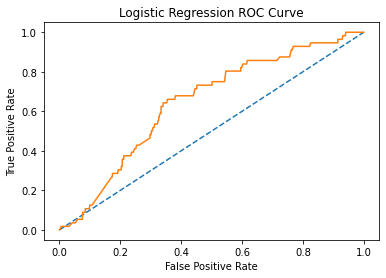

In [52]:
y_pred_prob = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [53]:
roc_auc_score(y_test, y_pred_prob)

0.6452793078259496

Text(0.5, 1.0, 'Accuracy Score: 0.66')

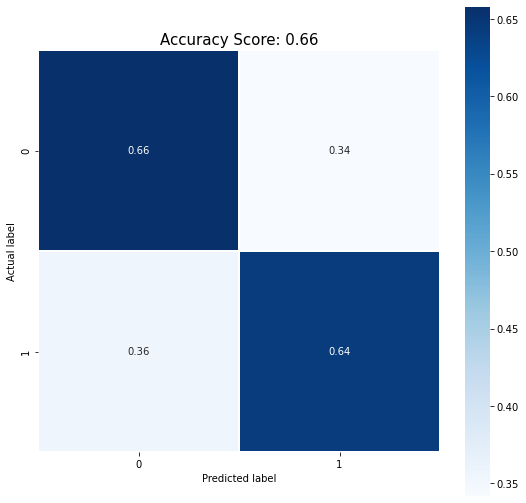

In [54]:
plt.figure(figsize=(9,9))

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(round(score,2))
plt.title(all_sample_title, size = 15)